# ADS 509 Assignment 3.1 by Sanjay Regi Philip

# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


## Package Import and Defining Functions

In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords 
sw = set(stopwords.words("english")) ## use set to speed up comparisons

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    # Place your Module 2 solution here
    
    counter = Counter(tokens)
    characters = ''.join(tokens)
    
    # Fill in the correct values here. 
    num_tokens = sum(counter.values())
    num_unique_tokens = len(counter.keys())
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = len(characters)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(counter.most_common(5))
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    
    
def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    # modify this function to remove stopwords
    
    return [t for t in tokens if t.lower() not in sw]
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
   
    text = text.split(" ")
    text = list(filter(str.strip, text)) ## removes unnecessary white space characters
     
    return(text)

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [3]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/sanjay/Library/CloudStorage/OneDrive-Personal/USD/ADS 509/Module3/M1 Results/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [4]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [5]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [6]:
# Read in the lyrics data
import os

## Function to remove artist leading name prefix for song file names
def remove_filename_prefix(text, prefix):
    if text.startswith(prefix):
        return text[len(prefix):]
    return text

## Function to read in lyrics from artist directory
def read_lyrics(path, prefix, artist_name):
    
    lyrics_dict = defaultdict(dict)
    artist_df = pd.DataFrame(columns=['Artist', 'Song', 'Lyrics'])
    artist_df['Artist'] = artist_name
    
    for filename in os.listdir(path):
        name, file_extension = os.path.splitext(filename)
        song_name = remove_filename_prefix(name, prefix)
        
        file = open(path+filename,"r", encoding='unicode_escape')
        content = file.read()
        file.close()
        
        ## save results to dictionary
        lyrics_dict[artist_name][song_name] = content
        
        ## save results to dataframe
        
        new_row = pd.DataFrame({'Song': [song_name], 'Lyrics': [content]})
        #artist_df = artist_df.append(new_row, ignore_index = True) ## .append will be deprecated function
        artist_df = pd.concat([artist_df, new_row])
         
        
    return lyrics_dict, artist_df


# Read in lyrics for Cher
path_cher = data_location + lyrics_folder + "cher/"
prefix_cher = "cher_"
artist_name_cher = "Cher"

cher_lyrics, cher_df = read_lyrics(path_cher, prefix_cher, artist_name_cher)
cher_df['Artist']= 'Cher'


# Read in lyrics for Robyn
path_robyn = data_location + lyrics_folder + "robyn/"
prefix_robyn = "robyn_"
artist_name_robyn = "Robyn"

robyn_lyrics, robyn_df = read_lyrics(path_robyn, prefix_robyn, artist_name_robyn)
robyn_df['Artist'] = 'Robyn'


# Combine Dictionary for both artists' lyrics
lyrics_dict = {"Cher": cher_lyrics,
               "Robyn": robyn_lyrics}

In [7]:
## Quick data clean up to remove unnecessary characters
lyrics_df = pd.concat([cher_df, robyn_df])
lyrics_df['Lyrics'] = lyrics_df['Lyrics'].str.replace(r'"(.+?)"', '') ## removes song name in quotes
lyrics_df['Lyrics'] = lyrics_df['Lyrics'].str.replace(r'\n', ' ') ## removes "/n" signifying new lines

/var/folders/j0/d7hvm8k10b933vg5dldl__9h0000gn/T/ipykernel_20811/1893873131.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  lyrics_df['Lyrics'] = lyrics_df['Lyrics'].str.replace(r'"(.+?)"', '') ## removes song name in quotes
/var/folders/j0/d7hvm8k10b933vg5dldl__9h0000gn/T/ipykernel_20811/1893873131.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  lyrics_df['Lyrics'] = lyrics_df['Lyrics'].str.replace(r'\n', ' ') ## removes "/n" signifying new lines


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [8]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

## pipelines turns tokens to lowercase, removes punctuation, tokenizes, and removes stop words
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_df["Tokens"] = lyrics_df["Lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_df["num_tokens"] = lyrics_df["Tokens"].map(len) 

twitter_data["Tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["Tokens"].map(len) 


In [9]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [10]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","Tokens"]]

,artist,description,Tokens
413547,cher,✌,[✌]
612854,cher,"Kim Grundy ✌️Fitness Editor, @byrdiebeauty ❤️ ...","[kim, grundy, ✌️fitness, editor, byrdiebeauty,..."
607814,cher,Hood baby? Hood baby. 🥱,"[hood, baby, hood, baby, 🥱]"
23767,cher,note: this is just a fan account of @chaelinCL...,"[note, fan, account, chaelincl, 🍒, baby, gzb, ..."
2253382,cher,# No matter how many fish are in the sea there...,"[#, matter, many, fish, sea, always, perfect, ..."
2888589,cher,I ❤️ Prov 4:23 IG @indnick91..getting to know ...,"[❤️, prov, 423, ig, indnick91getting, know, lo..."
3992724,cher,"Online 99.99% of the time, and it keeps me up ...","[online, 9999, time, keeps, night, sheherあたし, ..."
1343065,cher,"She/her. Mom, Jewish American Professor, BAT. ...","[sheher, mom, jewish, american, professor, bat..."
3008704,cher,12\12\1985 ☀,"[12121985, ☀]"
859782,cher,TAMU 19 UTSW 23 👩🏼‍⚕️ Every action has its equ...,"[tamu, 19, utsw, 23, 👩🏼‍⚕️, every, action, equ..."


# missing emoji code

With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One area that I had implemented was removing extra white space characters. I found that there were white space characters that were being captured as individual tokens and so I added an extra step when tokenizing to remove them. A possible future improvement would be to find another way to handle contractions. A lot of the most frequent words were contractions which are really a combination of two words and may be interesting to see split.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [11]:
## return lyrics for the individual artists
cher_lyrics_df = lyrics_df.loc[lyrics_df['Artist'] == 'Cher']
robyn_lyrics_df = lyrics_df.loc[lyrics_df['Artist'] == 'Robyn']

## user function to take a split list of tokens and return one list with the tokens all included
def flatten(l):
    return [item for sublist in l for item in sublist]

In [12]:
print("Descriptive Stats for Cher's Lyrics")
descriptive_stats(flatten(cher_lyrics_df['Tokens']))

Descriptive Stats for Cher's Lyrics
There are 35132 tokens in the data.
There are 3676 unique tokens in the data.
There are 168796 characters in the data.
The lexical diversity is 0.105 in the data.
[('love', 962), ('im', 511), ('know', 480), ('dont', 422), ('youre', 324)]


[35132, 3676, 0.10463395195263578, 168796]

In [13]:
print("Descriptive Stats for Robyn's Lyrics")
descriptive_stats(flatten(robyn_lyrics_df['Tokens']))

Descriptive Stats for Robyn's Lyrics
There are 14997 tokens in the data.
There are 2132 unique tokens in the data.
There are 72815 characters in the data.
The lexical diversity is 0.142 in the data.
[('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 249)]


[14997, 2132, 0.14216176568647063, 72815]

Q: what observations do you make about these data? 

A: Two of the top 5 words between lyrics of both artists are the same and they are "im" and "dont". What's interesting about both these words are that they are contractions, which are made up of two words put together. Cher's lyrics has another contraction in you're which is also one of the most frequent tokens.
Additionally, it's interesting to note that Robyn has a higher lexical diversity than Cher although Cher has significantly more tokens in this dataset. This could mean that Cher has more songs or lyrics in this dataset, but in those songs she uses the same words more often.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [14]:
## set constant for minumum number of times token must appear in corpora
n = 5

## function to count the frequency in a given corpora
def count_words(df, column='Tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

## find frequency of tokens in each of the 4 corproa
cher_lyrics_wordcount = count_words(cher_lyrics_df, min_freq=n)
robyn_lyrics_wordcount = count_words(robyn_lyrics_df, min_freq=n)

cher_twitter = twitter_data.loc[twitter_data['artist'] == 'cher']
robyn_twitter = twitter_data.loc[twitter_data['artist'] == 'robyn']
cher_twitter_wordcount = count_words(cher_twitter, min_freq=n)
robyn_twitter_wordcount = count_words(robyn_twitter, min_freq=n)

In [15]:
## find the total number of tokens per each corpora
cher_lyrics_total = len(flatten(cher_lyrics_df['Tokens']))
robyn_lyrics_total = len(flatten(robyn_lyrics_df['Tokens']))

cher_twitter_total = len(flatten(cher_twitter['Tokens']))
robyn_twitter_total = len(flatten(robyn_twitter['Tokens']))

In [16]:
## find concentration for each token in each corpora
cher_lyrics_wordcount['Cher Lyrics Concentration'] = cher_lyrics_wordcount['freq']/cher_lyrics_total
robyn_lyrics_wordcount['Robyn Lyrics Concentration'] = robyn_lyrics_wordcount['freq']/robyn_lyrics_total

cher_twitter_wordcount['Cher Twitter Concentration'] = cher_twitter_wordcount['freq']/cher_twitter_total
robyn_twitter_wordcount['Robyn Twitter Concentration'] = robyn_twitter_wordcount['freq']/robyn_twitter_total

In [17]:
## rename frequency column
cher_lyrics_wordcount = cher_lyrics_wordcount.rename(columns={"freq": "Cher Lyrics Freq"})
robyn_lyrics_wordcount = robyn_lyrics_wordcount.rename(columns={"freq": "Robyn Lyrics Freq"})

cher_twitter_wordcount = cher_twitter_wordcount.rename(columns={"freq": "Cher Twitter Freq"})
robyn_twitter_wordcount = robyn_twitter_wordcount.rename(columns={"freq": "Robyn Twitter Freq"})

In [18]:
## merge all tokens and descriptive statistics into 1 dataframe
lyrics_wordcount_df = cher_lyrics_wordcount.merge(robyn_lyrics_wordcount, on='token', how='inner')

twitter_wordcount_df = cher_twitter_wordcount.merge(robyn_twitter_wordcount, on='token', how='inner')

wordcount_df = lyrics_wordcount_df.merge(twitter_wordcount_df, on='token', how='inner')
wordcount_df['Tokens'] = wordcount_df.index

In [19]:
## Calculate the Total Frequency of a token across all 4 corpora
## This will be useful when calculating ratios

wordcount_df['Total Freq'] = wordcount_df['Cher Lyrics Freq'] + wordcount_df['Robyn Lyrics Freq'] + wordcount_df['Cher Twitter Freq'] + wordcount_df['Robyn Twitter Freq']

token_total = cher_lyrics_total + robyn_lyrics_total + cher_twitter_total + robyn_twitter_total

### Ratio Calculation Logic

The ratio will be the concentration of a token in a corpus, divided by the concentration of that token in the other 3 corpora. 
Total Frequncy is subtracted by the total of that given corpus and the token total is subtracted by the total tokens of that given corpus.

In [20]:
## Calculation of Ratios
wordcount_df['Cher Lyrics Ratio'] = wordcount_df['Cher Lyrics Concentration']/((wordcount_df['Total Freq'] - wordcount_df['Cher Lyrics Freq'])/(token_total - cher_lyrics_total))
wordcount_df['Robyn Lyrics Ratio'] = wordcount_df['Robyn Lyrics Concentration']/((wordcount_df['Total Freq'] - wordcount_df['Robyn Lyrics Freq'])/(token_total - robyn_lyrics_total))
wordcount_df['Cher Twitter Ratio'] = wordcount_df['Cher Twitter Concentration']/((wordcount_df['Total Freq'] - wordcount_df['Cher Twitter Freq'])/(token_total - cher_twitter_total))
wordcount_df['Robyn Twitter Ratio'] = wordcount_df['Robyn Twitter Concentration']/((wordcount_df['Total Freq'] - wordcount_df['Robyn Twitter Freq'])/(token_total - robyn_twitter_total))

#### Top 10 Unique Tokens for Cher's Lyrics

In [21]:
top_cher_lyrics_ratio = wordcount_df.sort_values('Cher Lyrics Ratio', ascending=False).head(10)
top_cher_lyrics_ratio = top_cher_lyrics_ratio['Tokens']
print(top_cher_lyrics_ratio)

token
ooh            ooh
chorus      chorus
knock        knock
tonight    tonight
ohh            ohh
ooo            ooo
tears        tears
gonna        gonna
deny          deny
gotta        gotta
Name: Tokens, dtype: object


#### Top 10 Unique Tokens for Robyn's Lyrics

In [22]:
top_robyn_lyrics_ratio = wordcount_df.sort_values('Robyn Lyrics Ratio', ascending=False).head(10)
top_robyn_lyrics_ratio = top_robyn_lyrics_ratio['Tokens']
print(top_robyn_lyrics_ratio)

token
chorus      chorus
ooo            ooo
ohh            ohh
beat          beat
88              88
deny          deny
itll          itll
ooh            ooh
alright    alright
crash        crash
Name: Tokens, dtype: object


#### Top 10 Unique Tokens for Cher's Twitter Followers

In [23]:
top_cher_twitter_ratio = wordcount_df.sort_values('Cher Twitter Ratio', ascending=False).head(10)
top_cher_twitter_ratio = top_cher_twitter_ratio['Tokens']
print(top_cher_twitter_ratio)

token
god          god
proud      proud
faith      faith
friend    friend
woman      woman
truth      truth
stand      stand
boys        boys
two          two
mama        mama
Name: Tokens, dtype: object


#### Top 10 Unique Tokens for Robyn's Twitter Followers

In [24]:
top_robyn_twitter_ratio = wordcount_df.sort_values('Robyn Twitter Ratio', ascending=False).head(10)
top_robyn_twitter_ratio = top_robyn_twitter_ratio['Tokens']
print(top_robyn_twitter_ratio)

token
till            till
til              til
sound          sound
men              men
spinning    spinning
music          music
88                88
head            head
dance          dance
crash          crash
Name: Tokens, dtype: object


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: An interesting observation I had when looking at the top tokens for Cher's lyrics are that 3 of the top 10 tokens are ooh, ohh, and ooo which are not actual words and may actually be the same sound but just spelled differently. Also interesting is that ooo and ooh are in the top 10 of Robyn's lyrics which indicate that although they may be listed as infrequent in general, the ratios could be skewed by the fact that the twitter descriptions in total have significantly more tokens than the lyrics. Lastly, it's interesting to see that the twitter descriptions seem to have much more variety of words in their most popular tokens.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [25]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='Tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [26]:
## combine tokens for lyrics and twitter descriptions
lyrics_tokens = lyrics_df['Tokens']
twitter_tokens = twitter_data['Tokens']

tokens = pd.concat([lyrics_tokens, twitter_tokens])
tokens = tokens.to_frame()

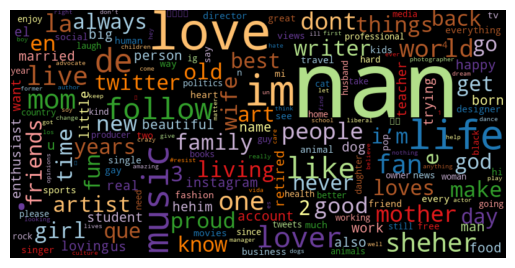

In [27]:
# create wordcloud
freq = count_words(tokens)
wordcloud(word_freq = freq['freq'])

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Many of the biggest words in the wordcloud seem to correspond with the frequent words found when performing descriptive statistics. Interesting to see that many of the words have a theme off love or affection, which is popular in pop music which the two artists are affiliated with, and also that many of the words are contractions or other slang language such as "gonna".